In [35]:
import jax
from jax.flatten_util import ravel_pytree
from jax.tree_util import tree_map, tree_structure
import jax.numpy as jnp
import optax

from bde.models.models import Fnn
from bde.training.trainer import FnnTrainer
from bde.bde_builder import BdeBuilder
from bde.viz.plotting import plot_pred_vs_true
from bde.data.dataloader import DataLoader
from bde.data.preprocessor import DataPreProcessor
from bde.loss.loss import  LossMSE
from bde.sampler.mile_wrapper import MileWrapper

from bde.sampler.warmup import custom_mclmc_warmup
from bde.sampler.probabilistic import ProbabilisticModel
from bde.sampler.prior import Prior, PriorDist

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import sys
import os

import pandas

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [36]:
data = fetch_openml(name="airfoil_self_noise", as_frame=True)

X = data.data.values   # shape (1503, 5)
y = data.target.values.reshape(-1, 1)  # shape (1503, 1)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

Xmu, Xstd = jnp.mean(X_train, 0), jnp.std(X_train, 0) + 1e-8
Ymu, Ystd = jnp.mean(y_train, 0), jnp.std(y_train, 0) + 1e-8

Xtr = (X_train - Xmu) / Xstd
Xte = (X_test  - Xmu) / Xstd
ytr = (y_train - Ymu) / Ystd
yte = (y_test  - Ymu) / Ystd

/Users/yellouz/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/datasets/_openml.py:320: UserWarning: Multiple active versions of the dataset matching the name airfoil_self_noise exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43919
- version 8, status: active
  url: https://www.openml.org/search?type=data&id=44957

  warn(warning_msg)


In [37]:
sizes = [5, 16, 16, 2]

In [38]:
bde = BdeBuilder(
        sizes, 
        n_members=1, 
        epochs=500, 
        optimizer=optax.adam(1e-3)
        )

In [39]:
bde.fit(
        x=Xtr, 
        y=ytr, 
        epochs=500
        )

0 1.06685209274292
100 0.43494778871536255
200 0.30201905965805054
300 0.25682613253593445
400 0.22302553057670593


In [40]:
initial_params = bde.all_fnns["fnn_0"]
prior = PriorDist.STANDARDNORMAL.get_prior()
model = ProbabilisticModel(module=bde.members[0], params=initial_params, prior=prior, n_batches=1)

logdensity_fn = lambda params: model.log_unnormalized_posterior(params, x=Xtr, y=ytr)

In [41]:
print(model.log_prior)

<bound method ProbabilisticModel.log_prior of <bde.sampler.probabilistic.ProbabilisticModel object at 0x132fdb0d0>>


In [42]:
warmup = custom_mclmc_warmup(
    logdensity_fn=logdensity_fn,
    diagonal_preconditioning=False,
    step_size_init=1e-3,
    desired_energy_var_start=0.5,
    desired_energy_var_end=0.1,
    trust_in_estimate=1.5,
    num_effective_samples=100,
    )

In [43]:
rng_key = jax.random.PRNGKey(1)
results = warmup.run(rng_key, position=initial_params, num_steps=1000)
print("step_size:", results.parameters.step_size)
print("L:", results.parameters.L)
post_end = logdensity_fn(results.state.position)
print("end-of-warmup post:", post_end)

---Initialize warmup---
---Search for optimal Parameters---
Initial L:  20.049938
step 0 | ok=True | step_size=0.0010000000474974513 | cap=3.4028234663852886e+38 | dE=-174.0
step 1 | ok=True | step_size=0.00043352702050469816 | cap=3.4028234663852886e+38 | dE=-0.25
step 2 | ok=True | step_size=0.00047798166633583605 | cap=3.4028234663852886e+38 | dE=0.0
step 3 | ok=True | step_size=0.0004843984788749367 | cap=3.4028234663852886e+38 | dE=0.25
step 4 | ok=True | step_size=0.0005139079876244068 | cap=3.4028234663852886e+38 | dE=0.0
step 5 | ok=True | step_size=0.0005186060443520546 | cap=3.4028234663852886e+38 | dE=-0.5
step 6 | ok=True | step_size=0.0005440953536890447 | cap=3.4028234663852886e+38 | dE=0.5
step 7 | ok=True | step_size=0.000565097841899842 | cap=3.4028234663852886e+38 | dE=-0.25
step 8 | ok=True | step_size=0.0005811461596749723 | cap=3.4028234663852886e+38 | dE=0.25
step 9 | ok=True | step_size=0.0005955121014267206 | cap=3.4028234663852886e+38 | dE=-0.25
step 10 | ok=Tr

In [44]:
sampler = MileWrapper(logdensity_fn, step_size=results.parameters.step_size , L=results.parameters.L,)
positions, infos, state = sampler.sample(rng_key=rng_key, init_position = results.state.position, num_samples = 1000, thinning=10)

In [45]:
# infos is something like MCLMCInfo(logdensity=..., kinetic_change=..., energy_change=...)
ld = jnp.ravel(infos.logdensity)       # log posterior per step, shape (S,)
dE = jnp.ravel(infos.energy_change)    # shape (S,)
kc = jnp.ravel(infos.kinetic_change)   # shape (S,)

print("finite?", bool(jnp.all(jnp.isfinite(ld))),
                  bool(jnp.all(jnp.isfinite(dE))),
                  bool(jnp.all(jnp.isfinite(kc))))
print("dE mean:", float(dE.mean()))
print("dE q05/median/q95:", [float(x) for x in jnp.quantile(dE, jnp.array([.05,.5,.95]))])


finite? True True True
dE mean: -0.0002500000118743628
dE q05/median/q95: [-0.5, 0.0, 0.375]


In [46]:
last = tree_map(lambda a: a[-1], positions)

In [47]:
fnn = bde.members[0]
fnn.params = last
pred = fnn.predict(Xte)

In [48]:
mu_n  = pred[..., 0:1]
sigma_n = 0.5 + 10.0 * jax.nn.sigmoid(pred[..., 1:2])

y_pred = mu_n * Ystd + Ymu
y_err  = sigma_n * Ystd
y_true = yte * Ystd + Ymu

print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape, "yerr shape:", y_err.shape)

y_true shape: (301, 1) y_pred shape: (301, 1) yerr shape: (301, 1)


In [49]:
lim_min = float(min(y_true.min(), y_pred.min()))
lim_max = float(max(y_true.max(), y_pred.max()))

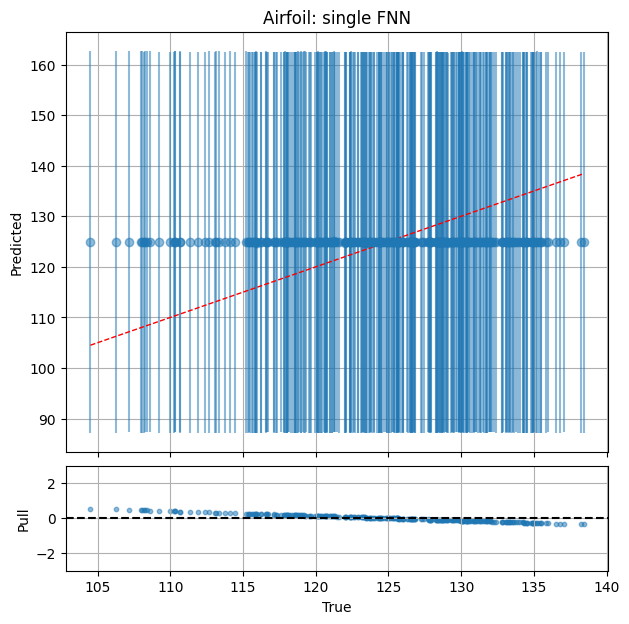

In [50]:
yt = np.asarray(y_true).ravel()
yp = np.asarray(y_pred).ravel()
ye = np.asarray(y_err).ravel()
ye = np.maximum(ye, 1e-8)  # guard

fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(2,1, height_ratios=[4,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.errorbar(yt, yp, yerr=ye, fmt='o', alpha=0.5)
m, M = float(min(yt.min(), yp.min())), float(max(yt.max(), yp.max()))
ax.plot([m,M],[m,M], 'r--', lw=1)
ax.set_ylabel("Predicted"); ax.set_title("Airfoil: single FNN"); ax.grid(True)
plt.setp(ax.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[1], sharex=ax)
pull = (yp - yt) / ye
ax2.axhline(0, color='k', ls='--')
ax2.scatter(yt, pull, s=10, alpha=0.5)
ax2.set_xlabel("True"); ax2.set_ylabel("Pull"); ax2.set_ylim(-3,3); ax2.grid(True)


In [51]:
y_mean = jnp.mean(y_train)
rmse_baseline = float(jnp.sqrt(jnp.mean((y_test - y_mean)**2)))
print("RMSE baseline (mean predictor):", rmse_baseline)

# R^2 for your trained model
r2 = 1.0 - float(jnp.sum((y_true - y_pred)**2) / jnp.sum((y_true - jnp.mean(y_true))**2))
print("R^2 (trained):", r2)

RMSE baseline (mean predictor): 7.080997467041016
R^2 (trained): -0.002030014991760254
